# IBOV D+1 (↑/↓) — **v5.2**

**Objetivo:** elevar a taxa de acerto diária com: (1) **tuning de threshold** por `accuracy` ou `balanced_accuracy`; (2) **abstenção** com banda de probabilidade; (3) **ensemble** (soft‑voting) e **stacking**; (4) **novas features** (streaks, regime de volatilidade); (5) opções de **alvo D+H** e **limiar de retorno**; e (6) **gráficos** completos (acurácia vs baseline, balanced, OOF, matrizes de confusão, cobertura x acurácia condicional e importância de features).

## Instalação (Colab/ambiente limpo) — opcional

In [193]:
# Rode esta célula apenas se faltar algum pacote:
!pip -q install yfinance ta scikit-learn seaborn joblib xgboost lightgbm catboost

## Imports e configuração

In [194]:
import os, json, warnings
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import yfinance as yf

try:
    from ta.momentum import RSIIndicator
    from ta.trend import MACD
    TA_OK = True
except Exception:
    TA_OK = False

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False
try:
    from lightgbm import LGBMClassifier
    LGB_OK = True
except Exception:
    LGB_OK = False
try:
    from catboost import CatBoostClassifier
    CAT_OK = True
except Exception:
    CAT_OK = False

from sklearn.base import clone
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_theme(context='notebook', style='whitegrid', palette='tab10')
print('OK | ta:', TA_OK, '| xgboost:', XGB_OK, '| lightgbm:', LGB_OK, '| catboost:', CAT_OK)

OK | ta: True | xgboost: True | lightgbm: True | catboost: True


## Parâmetros

In [195]:
fonte_dados = 'auto'   # 'auto' | 'yfinance' | 'csv'
csv_path    = 'Dados Historicos - Ibovespa.csv'
usar_intervalo_datas = True
data_inicio = '2015-01-01'
data_fim    = None
anos_retroceder = 10
ticker = '^BVSP'
ultimos_dias_teste = 30
n_splits_cv = 10
target_horizon = 5     # D+H (ex.: 1 ou 5)
target_return_thr = 0.0 # ex.: 0.003 (0,3%). Se >0, neutraliza retornos |ret| < thr
threshold_metric = 'accuracy'  # 'accuracy' ou 'balanced'
abst_p_lo, abst_p_hi = 0.40, 0.60  # banda para sinais fortes
use_ensemble = True
use_stacking = True
resultado_dir = 'resultados_v5_2'
os.makedirs(resultado_dir, exist_ok=True)
print('Parâmetros prontos')

Parâmetros prontos


## Funções de importação, preparação e features

In [196]:
def baixar_yfinance(ticker, usar_intervalo, data_inicio, data_fim, anos_retroceder=15):
    if usar_intervalo:
        di = pd.to_datetime(data_inicio).strftime('%Y-%m-%d') if data_inicio else None
        dfim = pd.to_datetime(data_fim).strftime('%Y-%m-%d') if data_fim else None
        df = yf.download(ticker, start=di, end=dfim, interval='1d', auto_adjust=False, progress=False)
    else:
        fim = datetime.today()
        inicio = fim - timedelta(days=anos_retroceder*365)
        df = yf.download(ticker, start=inicio.strftime('%Y-%m-%d'), end=fim.strftime('%Y-%m-%d'), interval='1d', auto_adjust=False, progress=False)
        if df is None or df.empty:
            df = yf.download(ticker, period=f'{anos_retroceder}y', interval='1d', auto_adjust=False, progress=False)
    return df

def preparar_base(df_raw: pd.DataFrame, origem: str) -> pd.DataFrame:
    if origem == 'yahoo':
        df = df_raw.copy()
        if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
        df = df.rename(columns={'Open':'Abertura','High':'Máxima','Low':'Mínima','Close':'Último','Adj Close':'Fechamento_Ajustado','Volume':'Vol.'}).reset_index()
        df = df.rename(columns={'Date':'Data'})
    else:
        df = df_raw.copy(); df.columns = [c.strip() for c in df.columns]
        df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
        for col in ['Último','Abertura','Máxima','Mínima']:
            s = pd.Series(df[col], dtype='string').str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(s, errors='coerce')
        if 'Vol.' in df.columns:
            s = pd.Series(df['Vol.'], dtype='string').str.upper()
            def _parse_vol(v):
                if v is None or pd.isna(v): return np.nan
                w = str(v).strip(); mult = 1.0
                if w.endswith('B'): mult=1e9; w=w[:-1]
                elif w.endswith('M'): mult=1e6; w=w[:-1]
                elif w.endswith('K'): mult=1e3; w=w[:-1]
                w = w.replace('.', '').replace(',', '.')
                try: return float(w)*mult
                except: return np.nan
            df['Vol.'] = s.apply(_parse_vol)
    df = df.sort_values('Data').reset_index(drop=True)
    df['Var%'] = df['Último'].pct_change().fillna(0) * 100
    df['pct_change'] = df['Último'].pct_change()
    for w in [3,7,14,21,30]: df[f'ma_{w}'] = df['Último'].rolling(w).mean()
    for w in [5,10,20]: df[f'vol_{w}'] = df['Último'].rolling(w).std()
    df['gap_ma3'] = df['Último'] - df['ma_3']
    df['dia_semana'] = df['Data'].dt.weekday
    df['range_pct'] = (df['Máxima'] - df['Mínima']) / df['Último']
    df['gap_open']  = (df['Abertura'] - df['Último'].shift(1)) / df['Último'].shift(1)
    df['body']      = (df['Último'] - df['Abertura']) / df['Último']
    for k in [1,2,5]: df[f'close_lag{k}'] = df['Último'].pct_change(k)
    up = (df['Último'].diff() > 0).astype(int); dn = (df['Último'].diff() < 0).astype(int)
    df['streak_up_3'] = up.rolling(3).sum(); df['streak_dn_3'] = dn.rolling(3).sum()
    rv = df['Último'].pct_change().rolling(10).std()
    try:
        df['vol_regime'] = pd.qcut(rv, q=3, labels=[0,1,2]).astype(float)
    except Exception:
        df['vol_regime'] = pd.qcut(rv.rank(method='first'), q=3, labels=[0,1,2]).astype(float)
    if TA_OK:
        df['rsi_14'] = RSIIndicator(close=df['Último'], window=14).rsi()
        macd = MACD(close=df['Último'], window_slow=26, window_fast=12, window_sign=9)
        df['macd_line'] = macd.macd(); df['macd_signal'] = macd.macd_signal(); df['macd_hist'] = macd.macd_diff()
    else:
        delta = df['Último'].diff(); upv = np.where(delta>0, delta, 0.0); dnv = -np.where(delta<0, delta, 0.0)
        roll_up = pd.Series(upv).rolling(14).mean(); roll_down = pd.Series(dnv).rolling(14).mean()
        rs = roll_up / (roll_down.replace(0, np.nan))
        df['rsi_14'] = 100 - (100/(1+rs))
        ema12 = df['Último'].ewm(span=12, adjust=False).mean(); ema26 = df['Último'].ewm(span=26, adjust=False).mean()
        macd_line = ema12 - ema26; signal = macd_line.ewm(span=9, adjust=False).mean()
        df['macd_line'] = macd_line; df['macd_signal'] = signal; df['macd_hist'] = macd_line - signal
    m20 = df['Último'].rolling(20).mean(); s20 = df['Último'].rolling(20).std()
    df['BB_width'] = (m20 + 2*s20) - (m20 - 2*s20)
    tr1 = df['Máxima'] - df['Mínima']; tr2 = (df['Máxima'] - df['Último'].shift(1)).abs(); tr3 = (df['Mínima'] - df['Último'].shift(1)).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1); df['ATR_14'] = df['TR'].rolling(14).mean()
    if 'Vol.' in df.columns and df['Vol.'].notna().any():
        obv = [0]
        for i in range(1, len(df)):
            if df['Último'].iat[i] > df['Último'].iat[i-1]: obv.append(obv[-1] + (0 if pd.isna(df['Vol.'].iat[i]) else df['Vol.'].iat[i]))
            elif df['Último'].iat[i] < df['Último'].iat[i-1]: obv.append(obv[-1] - (0 if pd.isna(df['Vol.'].iat[i]) else df['Vol.'].iat[i]))
            else: obv.append(obv[-1])
        df['obv'] = obv
    else: df['obv'] = np.nan
    return df

def criar_alvo(df: pd.DataFrame, H=1, ret_thr=0.0) -> pd.DataFrame:
    ret_H = df['Último'].shift(-H)/df['Último'] - 1.0
    if ret_thr > 0:
        mask = ret_H.abs() >= ret_thr
        df = df.loc[mask].copy()
    df['Target'] = (ret_H > ret_thr).astype(int)
    return df

## Importação + filtro por datas + criação do alvo

In [197]:
origem = None
if fonte_dados in ('auto','yfinance'):
    try:
        raw = baixar_yfinance(ticker, usar_intervalo_datas, data_inicio, data_fim, anos_retroceder)
        if raw is not None and not raw.empty:
            origem = 'yahoo'
            print('Dados via yfinance:', raw.index.min().date(), '→', raw.index.max().date(), 'linhas:', len(raw))
            df = preparar_base(raw, origem='yahoo')
        else:
            raise RuntimeError('Sem dados do Yahoo.')
    except Exception as e:
        print('Falha yfinance:', e)
        if fonte_dados == 'yfinance': raise
if origem is None:
    if not os.path.exists(csv_path): raise FileNotFoundError('CSV não encontrado: %s' % csv_path)
    raw_csv = pd.read_csv(csv_path)
    df = preparar_base(raw_csv, origem='csv')
    origem = 'csv'
    print('Dados carregados de CSV (Investing).')
if usar_intervalo_datas and (data_inicio or data_fim):
    di = pd.to_datetime(data_inicio) if data_inicio else df['Data'].min()
    dfim = pd.to_datetime(data_fim) if data_fim else df['Data'].max()
    df = df[(df['Data'] >= di) & (df['Data'] <= dfim)].copy()
df = criar_alvo(df, H=target_horizon, ret_thr=target_return_thr)
df = df.sort_values('Data').reset_index(drop=True)
print('Período normalizado:', df['Data'].min().date(), '→', df['Data'].max().date(), 'linhas:', len(df))
print(df.head(3))

Dados via yfinance: 2015-01-02 → 2026-01-20 linhas: 2742
Período normalizado: 2015-01-02 → 2026-01-20 linhas: 2742
Price       Data  Fechamento_Ajustado   Último   Máxima   Mínima  Abertura  \
0     2015-01-02              48512.0  48512.0  50005.0  48345.0   50005.0   
1     2015-01-05              47517.0  47517.0  48512.0  47264.0   48512.0   
2     2015-01-06              48001.0  48001.0  48061.0  47338.0   47517.0   

Price     Vol.      Var%  pct_change     ma_3  ...  vol_regime  rsi_14  \
0      2882100  0.000000         NaN      NaN  ...         NaN     NaN   
1      3866100 -2.051039   -0.020510      NaN  ...         NaN     NaN   
2      4559300  1.018583    0.010186  48010.0  ...         NaN     NaN   

Price  macd_line  macd_signal  macd_hist  BB_width      TR  ATR_14      obv  \
0            NaN          NaN        NaN       NaN  1660.0     NaN        0   
1            NaN          NaN        NaN       NaN  1248.0     NaN -3866100   
2            NaN          NaN        N

## Features, split temporal (30d) e baseline do mês

In [198]:
feature_cols = ['pct_change','gap_ma3','dia_semana','rsi_14','macd_line','macd_signal','macd_hist','BB_width','ATR_14','obv','range_pct','gap_open','body','close_lag1','close_lag2','close_lag5','ma_3','ma_7','ma_14','ma_21','ma_30','vol_5','vol_10','vol_20','streak_up_3','streak_dn_3','vol_regime']
df = df.dropna(subset=feature_cols + ['Target']).copy()
X_full = df[feature_cols].values; Y_full = df['Target'].values
split = len(X_full) - ultimos_dias_teste
if split <= 0: raise ValueError('Dados insuficientes para separar teste de %d dias' % ultimos_dias_teste)
X_train_full, X_test = X_full[:split], X_full[split:]
y_train, y_test = Y_full[:split], Y_full[split:]
print('Train:', X_train_full.shape, 'Test:', X_test.shape)
print('Período de teste:', df['Data'].iloc[split].date(), '→', df['Data'].iloc[-1].date())
ret_test = (df['Último'].iloc[-ultimos_dias_teste:].pct_change() > 0).astype(int)
baseline_up = float(ret_test.mean())
print('Baseline (sempre ↑) últimos %d pregões: %.3f' % (ultimos_dias_teste, baseline_up))

Train: (2679, 27) Test: (30, 27)
Período de teste: 2025-12-04 → 2026-01-20
Baseline (sempre ↑) últimos 30 pregões: 0.600


## Separação por família de modelos e registro

In [199]:
scaler_linear = StandardScaler()
X_train_lin = scaler_linear.fit_transform(X_train_full); X_test_lin  = scaler_linear.transform(X_test)
X_train_tree = X_train_full.copy(); X_test_tree = X_test.copy()
model_registry = {
 'LogReg': { 'family': 'linear', 'estimator': Pipeline([('sc', StandardScaler()), ('lr', LogisticRegression(max_iter=2000, class_weight='balanced'))]), 'prob': True },
 'SVM_Linear': { 'family': 'linear', 'estimator': CalibratedClassifierCV(LinearSVC(C=1.0, class_weight='balanced'), method='sigmoid', cv=3), 'prob': True },
 'RandomForest': { 'family': 'tree', 'estimator': RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_leaf=2, random_state=42, n_jobs=-1), 'prob': True },
}
if XGB_OK: model_registry['XGBoost'] = { 'family': 'tree', 'estimator': XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=1000, max_depth=5, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, reg_lambda=0.0, n_jobs=-1), 'prob': True }
if LGB_OK: model_registry['LightGBM'] = { 'family': 'tree', 'estimator': LGBMClassifier(n_estimators=1400, learning_rate=0.03, max_depth=-1, num_leaves=63, min_data_in_leaf=10, min_split_gain=0.0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, reg_lambda=0.0, random_state=42, force_col_wise=True, feature_pre_filter=False), 'prob': True }
if CAT_OK: model_registry['CatBoost'] = { 'family': 'tree', 'estimator': CatBoostClassifier(iterations=900, depth=5, learning_rate=0.05, loss_function='Logloss', random_seed=42, verbose=0), 'prob': True }
print('Modelos registrados:', list(model_registry.keys()))

Modelos registrados: ['LogReg', 'SVM_Linear', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']


## OOF + tuning de threshold (métrica configurável) e avaliação

In [200]:
def get_family_mats(family):
    return (X_train_lin, X_test_lin) if family=='linear' else (X_train_tree, X_test_tree)

def select_threshold(y_true, y_proba, metric='accuracy'):
    thresholds = np.linspace(0.3, 0.7, 41)
    best_thr, best_primary, best_secondary = 0.5, -1.0, -1.0
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        primary = acc if metric=='accuracy' else bacc
        secondary = bacc if metric=='accuracy' else acc
        if (primary > best_primary) or (primary == best_primary and secondary > best_secondary):
            best_primary, best_secondary, best_thr = primary, secondary, thr
    return best_thr, best_primary, best_secondary

def oof_threshold_train(model, Xtr, ytr, n_splits=5, metric='accuracy'):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_proba = np.zeros(len(ytr)); oof_mask = np.zeros(len(ytr), dtype=bool)
    for tr_idx, val_idx in tscv.split(Xtr):
        X_tr, X_val = Xtr[tr_idx], Xtr[val_idx]; y_tr, y_val = ytr[tr_idx], ytr[val_idx]
        mdl = clone(model); mdl.fit(X_tr, y_tr)
        try: proba = mdl.predict_proba(X_val)[:,1]
        except Exception:
            dec = mdl.decision_function(X_val); dec = (dec - dec.min())/(dec.max()-dec.min()+1e-9); proba = dec
        oof_proba[val_idx] = proba; oof_mask[val_idx] = True
    best_thr, _, _ = select_threshold(ytr[oof_mask], oof_proba[oof_mask], metric=metric)
    final_model = clone(model); final_model.fit(Xtr, ytr)
    y_oof_pred = (oof_proba[oof_mask] >= best_thr).astype(int)
    oof_acc  = accuracy_score(ytr[oof_mask], y_oof_pred)
    oof_bacc = balanced_accuracy_score(ytr[oof_mask], y_oof_pred)
    return final_model, best_thr, {'oof_acc':oof_acc, 'oof_bacc':oof_bacc}, oof_proba, oof_mask

def avaliar_no_teste(model, Xte, yte, thr):
    try: proba = model.predict_proba(Xte)[:,1]
    except Exception:
        dec = model.decision_function(Xte); dec = (dec - dec.min())/(dec.max()-dec.min()+1e-9); proba = dec
    yhat = (proba >= thr).astype(int)
    acc  = accuracy_score(yte, yhat)
    bacc = balanced_accuracy_score(yte, yhat)
    cm   = confusion_matrix(yte, yhat)
    rep  = classification_report(yte, yhat, zero_division=0)
    return acc, bacc, cm, rep, proba, yhat

## Treino dos modelos, ensemble e stacking

In [201]:
resultados = {}; confs = {}; probas = {}; models = {}
oof_probas_models = {}; oof_mask_ref = None
for name, cfg in model_registry.items():
    print('=== %s ===' % name)
    Xtr, Xte = get_family_mats(cfg['family'])
    est = cfg['estimator']
    mdl, thr, oof_metrics, oof_proba, oof_mask = oof_threshold_train(est, Xtr, y_train, n_splits=n_splits_cv, metric=threshold_metric)
    acc, bacc, cm, rep, proba_te, yhat_te = avaliar_no_teste(mdl, Xte, y_test, thr)
    resultados[name] = {'acc_test': float(acc), 'bacc_test': float(bacc), 'thr': float(thr), 'oof_acc': float(oof_metrics['oof_acc']), 'oof_bacc': float(oof_metrics['oof_bacc'])}
    confs[name] = cm; probas[name] = proba_te; models[name] = mdl; oof_probas_models[name] = oof_proba
    if oof_mask_ref is None: oof_mask_ref = oof_mask.copy()
    out = pd.DataFrame({'date': df['Data'].iloc[-ultimos_dias_teste:].values, 'fechamento': df['Último'].iloc[-ultimos_dias_teste:].values, 'real_up': y_test, 'pred_up': yhat_te, 'proba_up': proba_te})
    out.to_csv(os.path.join(resultado_dir, 'predicoes_teste_%s.csv' % name), index=False)
    joblib.dump(mdl, os.path.join(resultado_dir, 'modelo_%s.joblib' % name))
    print('OOF acc=%.3f | OOF bacc=%.3f | THR=%.2f' % (oof_metrics['oof_acc'], oof_metrics['oof_bacc'], thr))
    print('TEST acc=%.3f | TEST bacc=%.3f' % (acc, bacc))
    print('Confusion Matrix (Teste):', cm)
# Ensemble
if use_ensemble and len(oof_probas_models) >= 2:
    w = {k: max(v['oof_bacc'], 1e-6) for k,v in resultados.items()}
    s = sum(w.values()); w = {k: v/s for k,v in w.items()}
    oof_ens = np.zeros_like(y_train, dtype=float)
    for m, p in oof_probas_models.items(): oof_ens += w.get(m,0.0) * p
    thr_ens, _, _ = select_threshold(y_train[oof_mask_ref], oof_ens[oof_mask_ref], metric=threshold_metric)
    proba_ens_test = np.zeros_like(y_test, dtype=float)
    for m, p in probas.items(): proba_ens_test += w.get(m,0.0) * p
    yhat_ens = (proba_ens_test >= thr_ens).astype(int)
    acc_ens  = accuracy_score(y_test, yhat_ens)
    bacc_ens = balanced_accuracy_score(y_test, yhat_ens)
    cm_ens   = confusion_matrix(y_test, yhat_ens)
    resultados['Ensemble'] = {'acc_test': float(acc_ens), 'bacc_test': float(bacc_ens), 'thr': float(thr_ens), 'oof_acc': float('nan'), 'oof_bacc': float('nan')}
    confs['Ensemble'] = cm_ens; probas['Ensemble'] = proba_ens_test
    pd.DataFrame({'date': df['Data'].iloc[-ultimos_dias_teste:].values, 'fechamento': df['Último'].iloc[-ultimos_dias_teste:].values, 'real_up': y_test, 'pred_up': yhat_ens, 'proba_up': proba_ens_test}).to_csv(os.path.join(resultado_dir, 'predicoes_teste_Ensemble.csv'), index=False)
    print('[Ensemble] TEST acc=%.3f | TEST bacc=%.3f | thr=%.2f' % (acc_ens, bacc_ens, thr_ens))
# Stacking
if use_stacking and len(oof_probas_models) >= 2:
    base_models = sorted(list(oof_probas_models.keys()))
    X_meta_oof = np.column_stack([oof_probas_models[m][oof_mask_ref] for m in base_models])
    y_meta_oof = y_train[oof_mask_ref]
    tscv = TimeSeriesSplit(n_splits=n_splits_cv)
    meta_oof_proba = np.zeros(len(y_meta_oof))
    for tr, vl in tscv.split(X_meta_oof):
        meta = LogisticRegression(max_iter=2000, class_weight='balanced')
        meta.fit(X_meta_oof[tr], y_meta_oof[tr])
        meta_oof_proba[vl] = meta.predict_proba(X_meta_oof[vl])[:,1]
    thr_meta, _, _ = select_threshold(y_meta_oof, meta_oof_proba, metric=threshold_metric)
    meta_final = LogisticRegression(max_iter=2000, class_weight='balanced')
    meta_final.fit(X_meta_oof, y_meta_oof)
    X_meta_test = np.column_stack([probas[m] for m in base_models if m in probas])
    proba_meta_test = meta_final.predict_proba(X_meta_test)[:,1]
    yhat_meta = (proba_meta_test >= thr_meta).astype(int)
    acc_meta  = accuracy_score(y_test, yhat_meta)
    bacc_meta = balanced_accuracy_score(y_test, yhat_meta)
    cm_meta   = confusion_matrix(y_test, yhat_meta)
    resultados['Stacking'] = {'acc_test': float(acc_meta), 'bacc_test': float(bacc_meta), 'thr': float(thr_meta), 'oof_acc': float('nan'), 'oof_bacc': float('nan')}
    confs['Stacking'] = cm_meta; probas['Stacking'] = proba_meta_test
    pd.DataFrame({'date': df['Data'].iloc[-ultimos_dias_teste:].values, 'fechamento': df['Último'].iloc[-ultimos_dias_teste:].values, 'real_up': y_test, 'pred_up': yhat_meta, 'proba_up': proba_meta_test}).to_csv(os.path.join(resultado_dir, 'predicoes_teste_Stacking.csv'), index=False)
    print('[Stacking] TEST acc=%.3f | TEST bacc=%.3f | thr=%.2f' % (acc_meta, bacc_meta, thr_meta))
best = max(resultados, key=lambda k: resultados[k]['acc_test'])
print('>>> Vencedor:', best, '| Acc teste (30d):', round(resultados[best]['acc_test'],3))
summary = {'winner':best,'metrics':resultados,'baseline_up':float(baseline_up),'period':{'train_start':str(df['Data'].iloc[0].date()),'train_end':str(df['Data'].iloc[split-1].date()),'test_start':str(df['Data'].iloc[split].date()),'test_end':str(df['Data'].iloc[-1].date())},'feature_cols':feature_cols,'origin':origem,'threshold_metric':threshold_metric,'target_horizon':int(target_horizon),'target_return_thr':float(target_return_thr)}
with open(os.path.join(resultado_dir, 'resumo_v5_2.json'), 'w', encoding='utf-8') as f: json.dump(summary, f, ensure_ascii=False, indent=2)
print('Artefatos em:', os.path.abspath(resultado_dir))

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

## Gráficos: acurácia vs baseline, balanced accuracy, OOF e matrizes de confusão

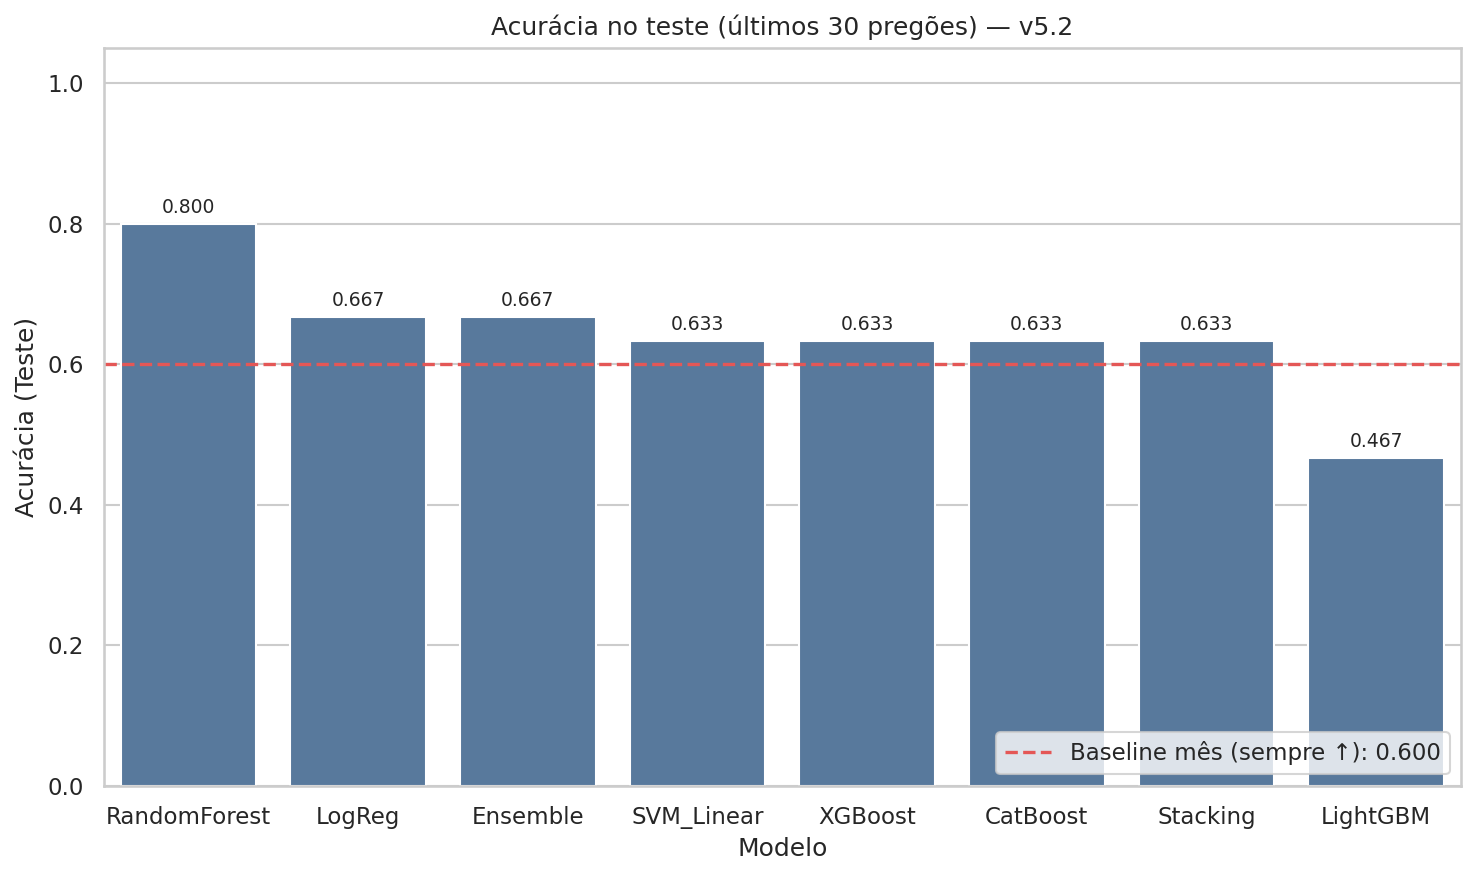

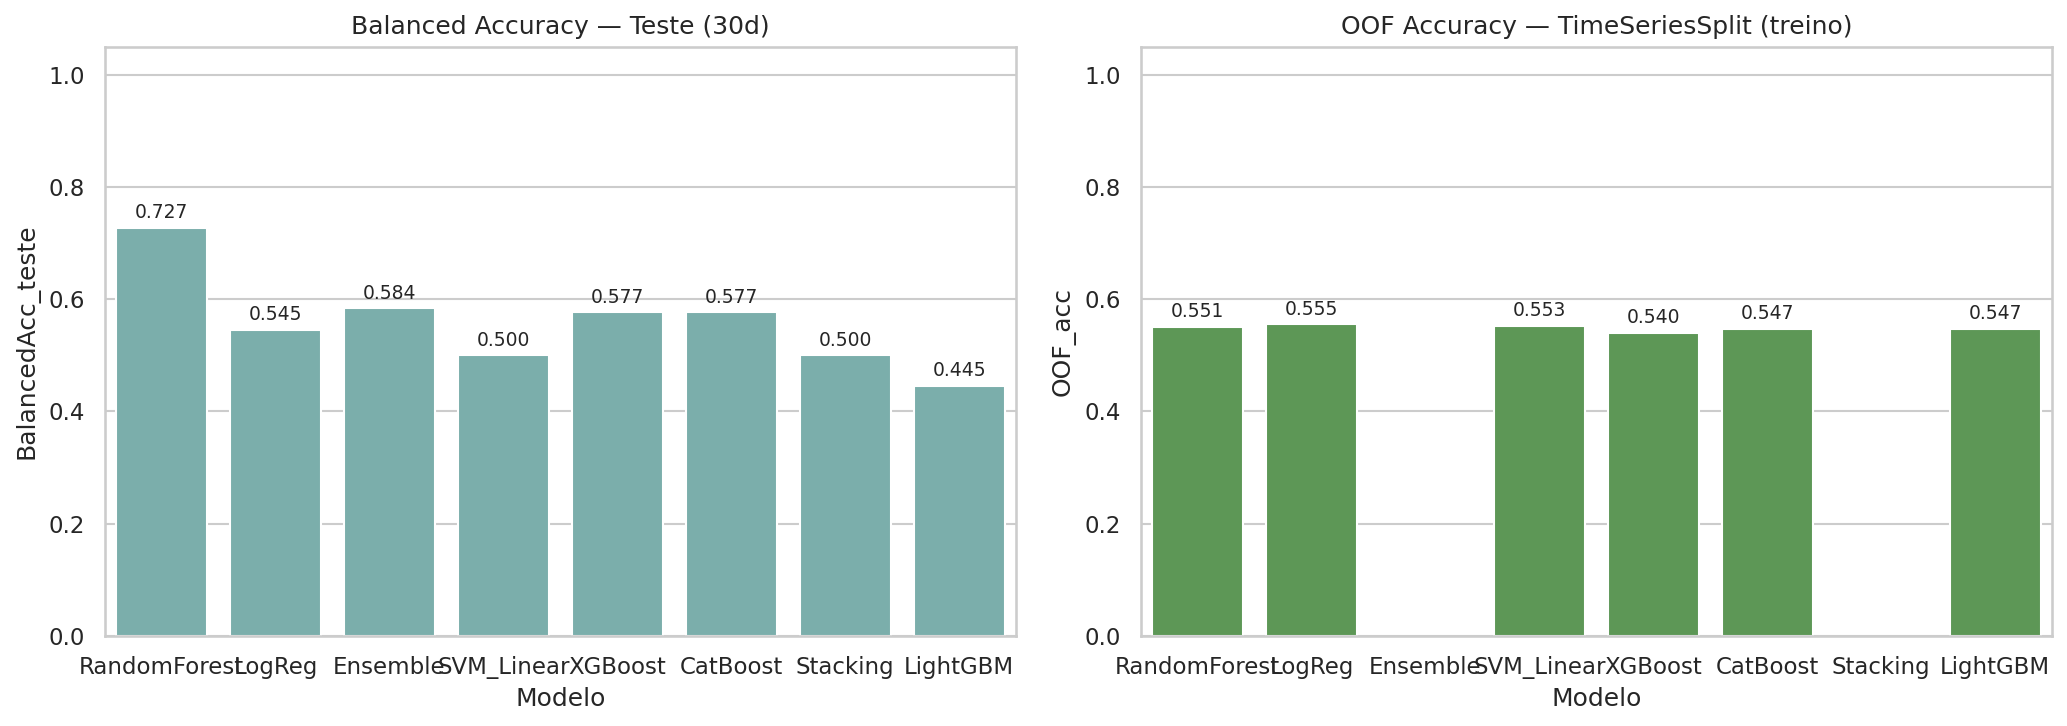

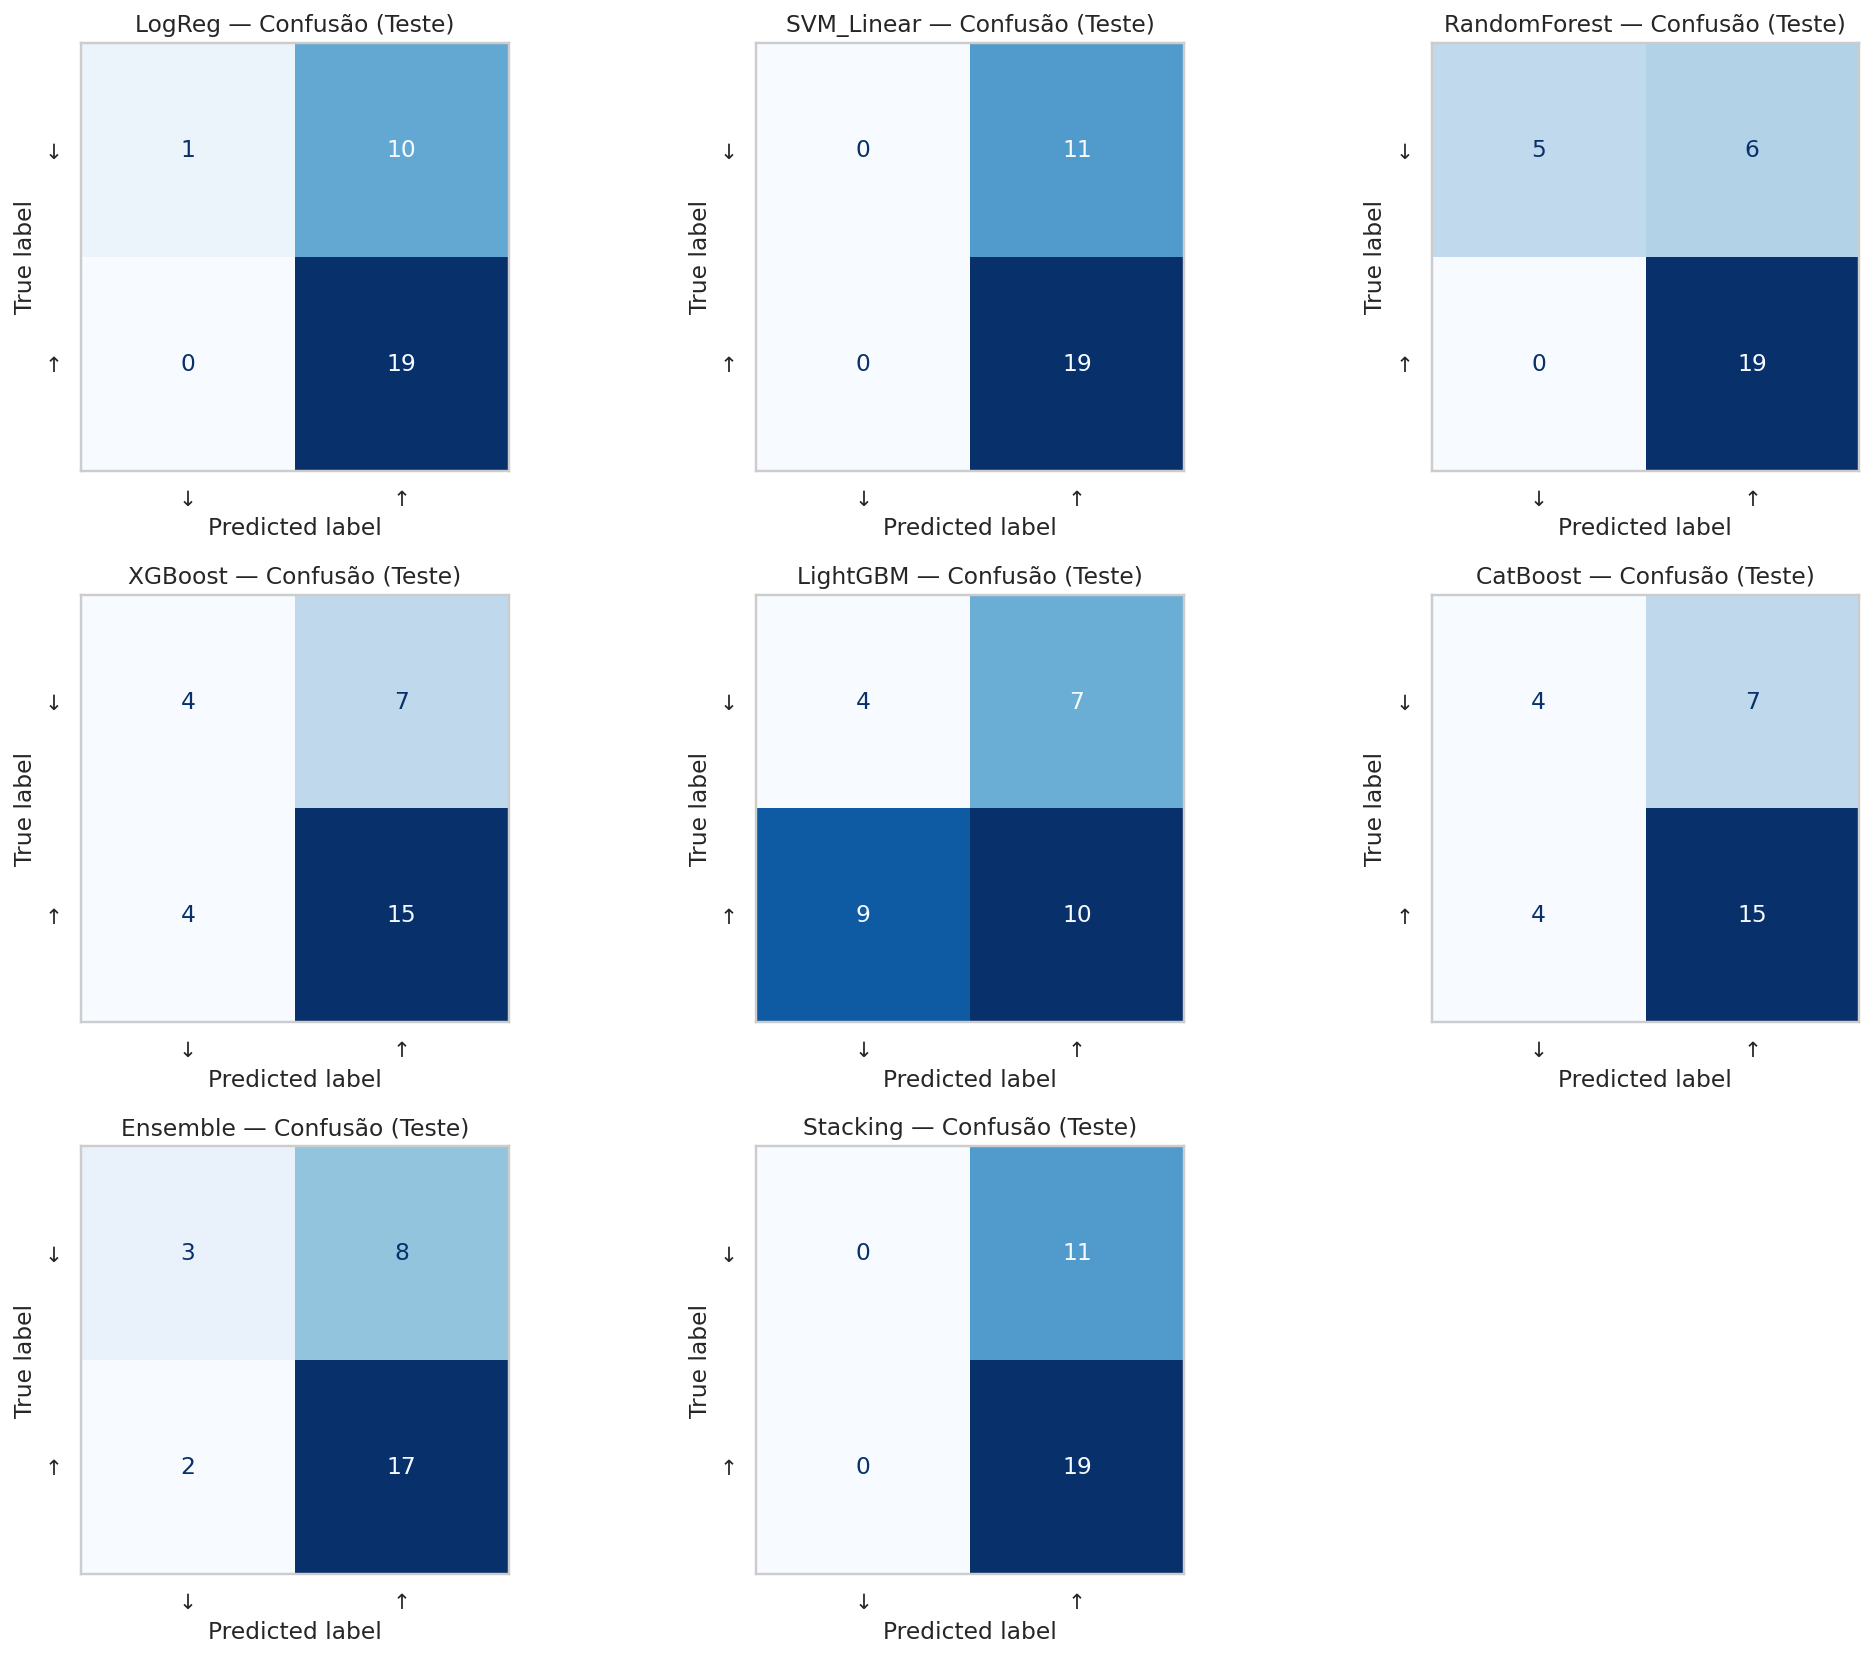

In [202]:
rows = []
for nome, m in resultados.items(): rows.append({'Modelo': nome, 'Acc_teste': m.get('acc_test'), 'BalancedAcc_teste': m.get('bacc_test'), 'OOF_acc': m.get('oof_acc'), 'OOF_bacc': m.get('oof_bacc'), 'Threshold': m.get('thr')})
dfm = pd.DataFrame(rows).sort_values('Acc_teste', ascending=False)
fig, ax = plt.subplots(figsize=(10,6), dpi=150)
sns.barplot(data=dfm, x='Modelo', y='Acc_teste', ax=ax, color='#4C78A8')
ax.axhline(baseline_up, ls='--', lw=1.6, color='#E45756', label='Baseline mês (sempre ↑): %.3f' % baseline_up)
for i, v in enumerate(dfm['Acc_teste']):
    	if pd.notna(v): ax.text(i, v + 0.01, '%.3f' % v, ha='center', va='bottom', fontsize=9)
ax.set_title('Acurácia no teste (últimos %d pregões) — v5.2' % ultimos_dias_teste)
ax.set_ylabel('Acurácia (Teste)'); ax.set_xlabel('Modelo'); ax.set_ylim(0,1.05); ax.legend(loc='lower right')
plt.tight_layout(); plt.savefig(os.path.join(resultado_dir,'v5_2_acuracia_teste.png'), dpi=150); plt.show()
fig2, axes = plt.subplots(1,2, figsize=(14,5), dpi=150)
sns.barplot(data=dfm, x='Modelo', y='BalancedAcc_teste', ax=axes[0], color='#72B7B2'); axes[0].set_title('Balanced Accuracy — Teste (%dd)' % ultimos_dias_teste); axes[0].set_ylim(0,1.05)
for i, v in enumerate(dfm['BalancedAcc_teste']):
    	if pd.notna(v): axes[0].text(i, v + 0.01, '%.3f' % v, ha='center', va='bottom', fontsize=9)
sns.barplot(data=dfm, x='Modelo', y='OOF_acc', ax=axes[1], color='#54A24B'); axes[1].set_title('OOF Accuracy — TimeSeriesSplit (treino)'); axes[1].set_ylim(0,1.05)
for i, v in enumerate(dfm['OOF_acc']):
    	if pd.notna(v): axes[1].text(i, v + 0.01, '%.3f' % v, ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.savefig(os.path.join(resultado_dir,'v5_2_balanced_oof.png'), dpi=150); plt.show()
n = len(confs); cols = min(3, n); rows_cf = int(np.ceil(n/cols))
fig3, axes3 = plt.subplots(rows_cf, cols, figsize=(5*cols, 4*rows_cf), dpi=140)
axes3 = np.array(axes3).reshape(rows_cf, cols) if n>1 else np.array([[axes3]])
for idx, (nome, cm) in enumerate(confs.items()):
    r, c = divmod(idx, cols); axc = axes3[r, c]
    disp = ConfusionMatrixDisplay(cm, display_labels=['↓','↑']); disp.plot(ax=axc, cmap='Blues', colorbar=False)
    axc.set_title('%s — Confusão (Teste)' % nome); axc.grid(False)
for k in range(idx+1, rows_cf*cols): r, c = divmod(k, cols); fig3.delaxes(axes3[r,c])
plt.tight_layout(); plt.savefig(os.path.join(resultado_dir,'v5_2_matrizes_confusao.png'), dpi=150); plt.show()

## Acurácia **condicional** com **abstenção** (banda de probabilidade)

         Modelo  Acurácia_Cond  Cobertura
2  RandomForest       1.000000   0.166667
5      CatBoost       0.565217   0.766667
6      Ensemble       0.529412   0.566667
3       XGBoost       0.500000   0.666667
4      LightGBM       0.461538   0.866667
0        LogReg       0.333333   0.200000
1    SVM_Linear       0.000000   0.033333
7      Stacking            NaN   0.000000


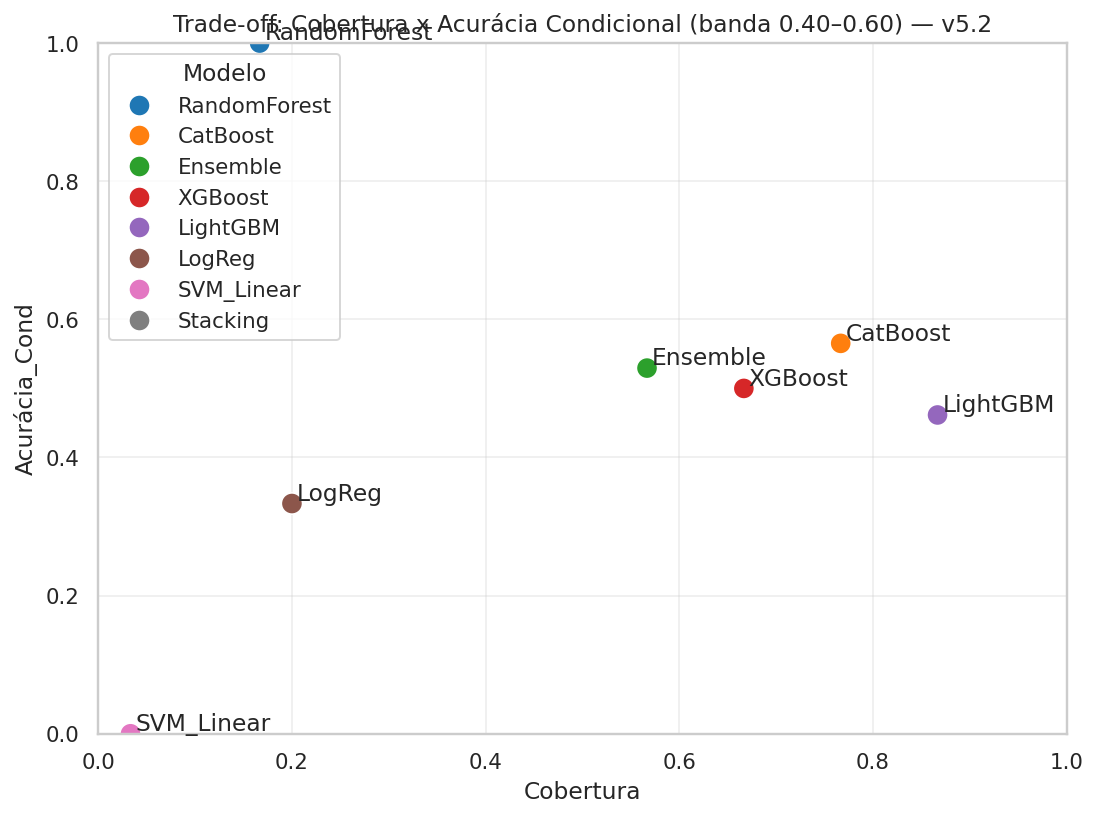

In [203]:
linhas = []
for nome, p in probas.items():
    mask_buy  = p >= abst_p_hi
    mask_sell = p <= abst_p_lo
    mask_take = mask_buy | mask_sell
    if mask_take.sum() == 0:
        acc_cond = np.nan
    else:
        y_pred = np.where(mask_buy, 1, 0)
        acc_cond = (y_pred[mask_take] == y_test[mask_take]).mean()
    cobertura = mask_take.mean()
    linhas.append({'Modelo': nome, 'Acurácia_Cond': acc_cond, 'Cobertura': cobertura})
df_cond = pd.DataFrame(linhas).sort_values('Acurácia_Cond', ascending=False)
print(df_cond)
plt.figure(figsize=(8,6), dpi=140)
sns.scatterplot(data=df_cond, x='Cobertura', y='Acurácia_Cond', hue='Modelo', s=120)
for i, r in df_cond.iterrows(): plt.text(r['Cobertura']+0.005, r['Acurácia_Cond']+0.005, r['Modelo'])
plt.title('Trade-off: Cobertura x Acurácia Condicional (banda %.2f–%.2f) — v5.2' % (abst_p_lo, abst_p_hi))
plt.xlim(0, 1); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(resultado_dir,'v5_2_cobertura_x_acuracia_cond.png'), dpi=150); plt.show()

## Importância de features (se vencedor for árvore/boosting)

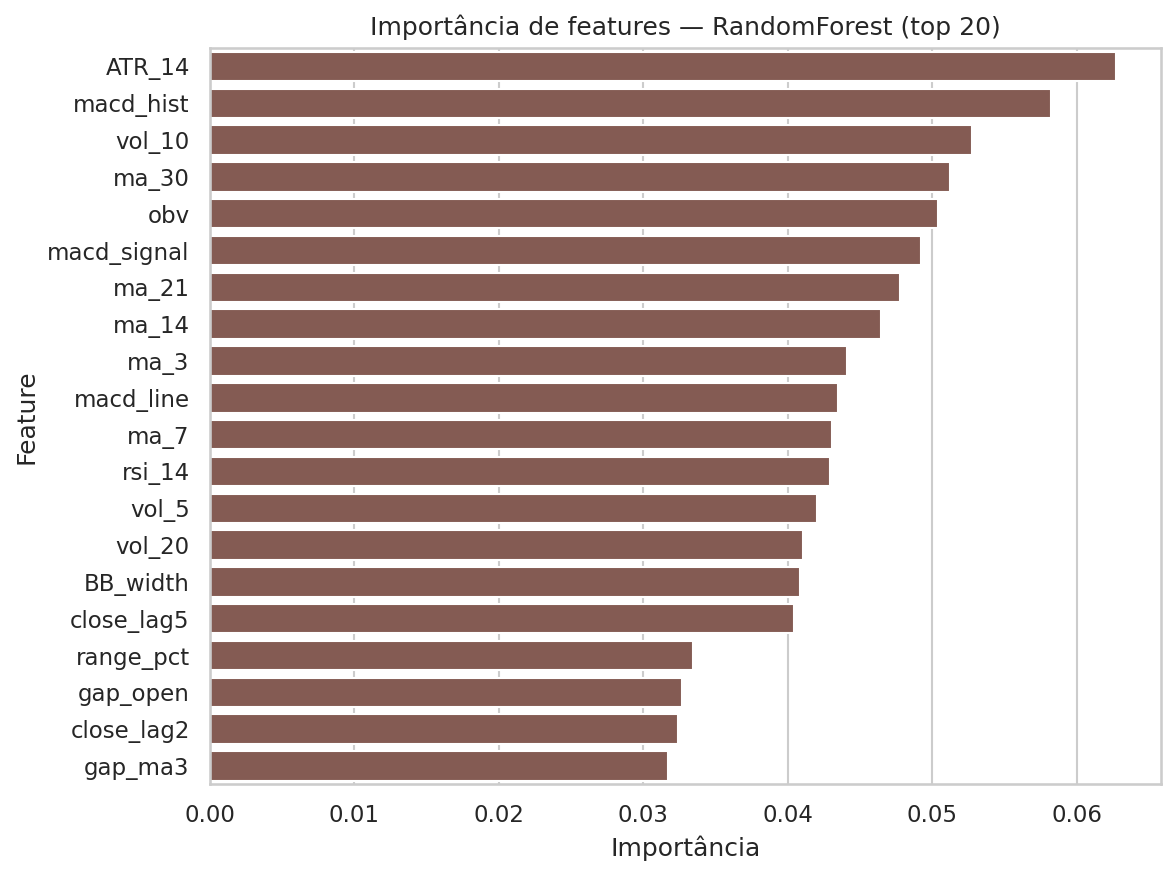

In [204]:
winner = max(resultados, key=lambda k: resultados[k]['acc_test'])
if winner in ['RandomForest','XGBoost','LightGBM','CatBoost']:
    try:
        mdl_path = os.path.join(resultado_dir, 'modelo_%s.joblib' % winner)
        mdl = joblib.load(mdl_path)
        importances = mdl.feature_importances_
        imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,6), dpi=150)
        sns.barplot(x=imp.values, y=imp.index, color='#8C564B')
        plt.title('Importância de features — %s (top 20)' % winner); plt.xlabel('Importância'); plt.ylabel('Feature')
        plt.tight_layout(); plt.savefig(os.path.join(resultado_dir,'v5_2_feature_importance.png'), dpi=150); plt.show()
    except Exception as e:
        print('Não foi possível extrair importâncias de features:', e)
else:
    print('Modelo vencedor não é de árvore/boosting — pulando importância de features.')